# Isochrones

**Objetive:** <br>
The following notebook shows the step-by-step to calculate isochrones using the [mapbox API](https://docs.mapbox.com/playground/isochrone/). Please read how the API works in this [link](https://docs.mapbox.com/playground/isochrone/) before running the code.<br>

Author: Laura Goyeneche, Consultant SPH, lauragoy@iadb.org <br>
Created: March 20, 2023

## 1. Basics

In [1]:
%%capture
# Libraries
import os 
import re
import time
import dotenv
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from geopandas.tools import sjoin

# Modules
from utils import get_iadb, get_country_shp
from utils import *

In [2]:
# Working environments
dotenv.load_dotenv()
sclbucket   = os.environ.get("sclbucket")
scldatalake = os.environ.get("scldatalake")

## 2. Inputs

In [3]:
# Country names 
data = get_iadb()

In [33]:
# Infrastructure
amenity = "healthcare"
group   = "official"
path    = f"../data/0-raw/infrastructure/{amenity}_facilities_{group}.csv"

# Countries with official data 
infrastructure = pd.read_csv(path, low_memory = False)

## 3. Calculate isochrones

### 3.1. Map isochrone for one health center

In [5]:
# Inputs
generalize = 500
base_url   = "https://api.mapbox.com/isochrone/v1/mapbox/"
token      = os.environ.get("access_token_dp")
profile    = ['driving','walking','cycling']
minutes    = [10,20,30,45]
geo        = "SLV"
data       = infrastructure[infrastructure.isoalpha3 == geo]

In [6]:
# Example
x    = data.lon.iloc[0]
y    = data.lat.iloc[0]
min_ = minutes[0]
cat  = profile[0]
url  = f'{base_url}{cat}/{x},{y}?contours_minutes={min_}&generalize={generalize}&polygons=true&access_token={token}'

# Request isochrones
response = requests.get(url).json()
features = response['features'][0]

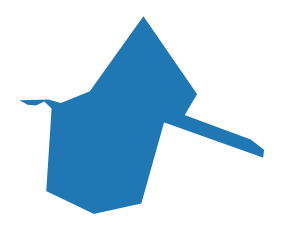

In [7]:
# Plot isochrone
gpd.GeoDataFrame.from_features(response['features']).plot()
plt.axis('off')
plt.show()

### 3.2. Country multipolygon

In [8]:
# Inputs 
generalize = 500
base_url   = "https://api.mapbox.com/isochrone/v1/mapbox/"
token      = os.environ.get("access_token_dp")
profile    = ['driving','walking','cycling']
minutes    = [10,20,30,45]
geo        = "SLV"
data       = infrastructure[infrastructure.isoalpha3 == geo]

# Data by amenity 
# This apply for financial facilities only 
by_amenity = 1 
if by_amenity == 1: 
    final_amenity = data.amenity.unique()[2]
    label_amenity = f"{amenity}/{final_amenity}"
    final_data    = data[data.amenity == final_amenity]
else:
    label_amenity = amenity
    final_data    = data

In [15]:
# Calculate isochrones
for min_ in minutes:
    for cat in profile:
        # List of individual isochrones
        isochrone = []

        for x,y in zip(final_data.lon, final_data.lat):
            # Define url
            url = f'{base_url}{cat}/{x},{y}?contours_minutes={min_}&generalize={generalize}&polygons=true&access_token={token}'

            # Request isochrones
            response = requests.get(url).json()
            features = response['features'][0]

            # Create GeoDataframe and append results 
            try:
                gpd_shp  = gpd.GeoDataFrame.from_features(response['features'])
                isochrone.append(gpd_shp)
            except:
                pass

            # Set time 
            time.sleep(2)

        # Master table 
        isochrones = pd.concat(isochrone)

        # Create one multipolygon
        isochrones = isochrones.dissolve()

        # Export isochrone 
        isochrones.to_file(f"../data/1-isochrones/{label_amenity}/{geo}-{cat}-{min_}.geojson", driver = "GeoJSON")

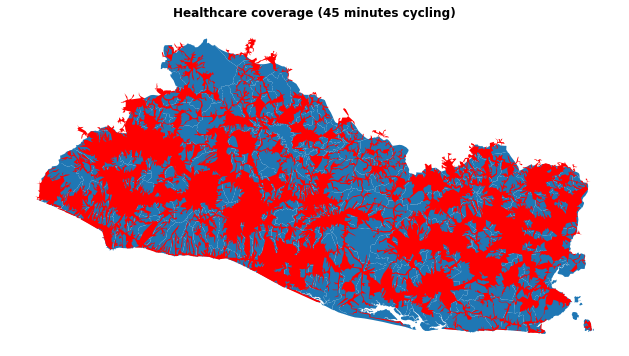

In [33]:
# Healthcare results
# Shapefile El Salvador
shp_ = get_country_shp(geo, level = 2)

# Plot country isochrones
fig, ax = plt.subplots(1, figsize = (12,6))
shp_.plot(ax = ax)
isochrones.plot(ax = ax, color = "red")
ax.set_title(f"{label_amenity.title()} coverage ({min_} minutes {cat})", fontweight = "bold")
ax.axis('off')
plt.show()

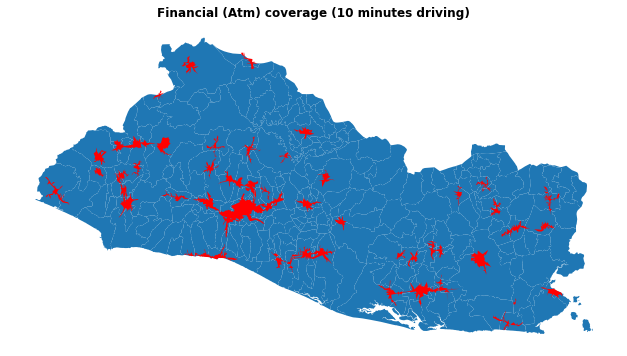

In [31]:
# Financial results
# Shapefile El Salvador
shp_ = get_country_shp(geo, level = 2)

# Plot country isochrones
fig, ax = plt.subplots(1, figsize = (12,6))
shp_.plot(ax = ax)
isochrones.plot(ax = ax, color = "red")
ax.set_title(f"{label_amenity.replace('/',' (').title()}) coverage ({min_} minutes {cat})", fontweight = "bold")
ax.axis('off')
plt.show()

### 3.3. LAC multipolygon

In [14]:
# Create list of country isochrone
amenity   = "financial"
isochrones = []
for code in data.isoalpha3: 
    isochrone = gpd.read_file(f"../data/1-isochrones/{amenity}/{code}-driving-30.geojson", driver = "GeoJSON")
    isochrones.append(isochrone)

# Master table    
isochrones = pd.concat(isochrones)

# Dissolve polygons
isochrones = isochrones.dissolve()

# Export data 
isochrones.to_file(f"../data/1-isochrones/{amenity}-driving-30.geojson", driver = "GeoJSON")